# Import

In [1]:
import os
import re
import json
import time
import datetime
import random
import glob
import importlib

import numpy as np
import pandas as pd
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import collections

random.seed(123)
np.random.seed(456)

# Hyper-parameters

In [2]:
MAX_LENGTH = 64 # max no. words for each sentence.
OVERLAP = 20 # if a sentence exceeds MAX_LENGTH, we split it to multiple sentences with overlapping

MAX_SAMPLE = 1000 # set a small number for experimentation, set None for production.

# Load data

In [3]:
train_path = './input/train.csv'
paper_train_folder = './input/train'
paper_sample_folder='./input/test'
sample_sub = pd.read_csv('./input/sample_submission.csv')

train = pd.read_csv(train_path)
train = train[:MAX_SAMPLE]
print(f'No. raw training rows: {len(train)}')
train = train.groupby('Id').agg({
    'pub_title': 'first',
    'dataset_title': '|'.join,
    'dataset_label': '|'.join,
    'cleaned_label': '|'.join
}).reset_index()

print(f'No. grouped training rows: {len(train)}')

No. raw training rows: 1000
No. grouped training rows: 982


In [4]:
train_num=int(len(train)*0.98)
validation_df=train.iloc[train_num:]
train=train.iloc[:train_num]
print("train_num,validation_num:",len(train),len(validation_df))

train_num,validation_num: 962 20


In [5]:
def read_papers(paper_folder,data_df):
    papers = {}
    for paper_id in data_df['Id'].unique():
        with open(f'{paper_folder}/{paper_id}.json', 'r') as f:
            paper = json.load(f)
            papers[paper_id] = paper
    return papers

# Transform data to NER format

In [9]:

def clean_training_text(txt):
    """
    similar to the default clean_text function but without lowercasing.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt)).strip()

def shorten_sentences(sentences):
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

def find_sublist(big_list, small_list):
    all_positions = []
    for i in range(len(big_list) - len(small_list) + 1):
        if small_list == big_list[i:i+len(small_list)]:
            all_positions.append(i)
    
    return all_positions

def tag_sentence(sentence, labels): # requirement: both sentence and labels are already cleaned
    sentence_words = sentence.split()  
    if labels is not None and any(re.findall(f'\\b{label}\\b', sentence)
                                  for label in labels): # positive sample
        nes = ['O'] * len(sentence_words)
        for label in labels:
            label_words = label.split()

            all_pos = find_sublist(sentence_words, label_words)
            for pos in all_pos:
                nes[pos] = 'B'
                for i in range(pos+1, pos+len(label_words)):
                    nes[i] = 'I'

        return True, list(zip(sentence_words, nes))
        
    else: # negative sample
        nes = ['O'] * len(sentence_words)
        return False, list(zip(sentence_words, nes))
    
stop_list=["of","and","for","in","s"]
def isupper_new(sentence):
#     if "data" in sentence.lower() and "study" in sentence.lower():
#         return 1
    words=sentence.split(" ")
    
    for i in range(len(words)):
        if  words[i].isupper() and len(words[i])>3:
            return 1
#         elif words[i].lower() in ["data","study"]:
#             return 1
        elif words[i].istitle() and i<len(words)-1 :
            if words[i+1].istitle():
                return 1
            elif words[i+1] in stop_list and i<len(words)-2 and words[i+2].istitle():
                return 1
#         elif words[i].istitle==False and (words[i].isupper()==False) and (words[i].islower()==False)and len(words[i])>3:
#             return 1
    return 0

            

In [10]:
catch_nes=True
upp_cnt_sentence=0

if catch_nes:
    cnt_pos, cnt_neg = 0, 0 # number of sentences that contain/not contain labels
    ner_data = []
    papers_train=read_papers(paper_train_folder,train)
    pbar = tqdm(total=len(train))
    for i, id, dataset_label in train[['Id', 'dataset_label']].itertuples():
        # paper
        paper = papers_train[id]

        # labels
        labels = dataset_label.split('|')
        labels = [clean_training_text(label) for label in labels]

        # sentences
        sentences = set([clean_training_text(sentence) for section in paper 
                     for sentence in section['text'].split('.') 
                    ])
        for sentence in sentences:
            if isupper_new(sentence):
                upp_cnt_sentence+=1
        
        sentences = shorten_sentences(sentences) # make sentences short
        
        sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars
        
                    
        # positive sample
        for sentence in sentences:
            is_positive, tags = tag_sentence(sentence, labels)
            if is_positive:
                cnt_pos += 1
                ner_data.append(tags)
            
        # process bar
        pbar.update(1)
        pbar.set_description(f"Training data size: {cnt_pos} ")

    # shuffling
    random.shuffle(ner_data)
    
    print(len(ner_data)/upp_cnt_sentence)
    words_list,nes_list=[],[]
    for row in ner_data:
        words, nes = list(zip(*row))
        words_list.append(list(words))
        nes_list.append(list(nes))


Training data size: 81 :   6%|███▍                                                   | 61/962 [00:00<00:06, 145.47it/s]


Training data size: 152 :  13%|██████▊                                              | 123/962 [00:00<00:05, 147.47it/s]


Training data size: 251 :  19%|██████████▏                                          | 185/962 [00:01<00:05, 142.35it/s]


Training data size: 325 :  26%|█████████████▌                                       | 247/962 [00:01<00:05, 133.77it/s]


Training data size: 401 :  32%|█████████████████                                    | 309/962 [00:02<00:04, 134.03it/s]


Training data size: 490 :  39%|████████████████████▍                                | 372/962 [00:02<00:03, 149.10it/s]


Training data size: 582 :  45%|███████████████████████▉                             | 434/962 [00:03<00:03, 151.20it/s]


Training data size: 669 :  52%|███████████████████████████▎                         | 496/962 [00:03<00:03, 149.47it/s]


Training data size: 760 :  58%|██████████████████████████████▋                      | 558/962 [00:03<00:02, 142.50it/s]


Training data size: 832 :  64%|██████████████████████████████████▏                  | 620/962 [00:04<00:02, 144.59it/s]


Training data size: 909 :  71%|█████████████████████████████████████▌               | 682/962 [00:04<00:01, 145.41it/s]


Training data size: 995 :  77%|████████████████████████████████████████▉            | 744/962 [00:05<00:01, 142.67it/s]


Training data size: 1078 :  84%|███████████████████████████████████████████▌        | 806/962 [00:05<00:01, 142.90it/s]


Training data size: 1158 :  90%|██████████████████████████████████████████████▉     | 868/962 [00:06<00:00, 130.96it/s]


Training data size: 1245 :  97%|██████████████████████████████████████████████████▎ | 930/962 [00:06<00:00, 136.23it/s]


Training data size: 1347 : 100%|████████████████████████████████████████████████████| 962/962 [00:06<00:00, 130.19it/s]

0.020885339948833244


In [12]:
upp_cnt_label=0
stop_list=["of","and","for","in","s"]
for words in words_list:
    raw=upp_cnt_label
 
    for i in range(len(words)):
        if words[i].isupper() and len(words[i])>3:
            upp_cnt_label+=1
            break

        elif words[i].istitle() and i<len(words)-1 :
            if words[i+1].istitle():
                upp_cnt_label+=1
                break
            elif words[i+1] in stop_list and i<len(words)-2 and words[i+2].istitle():
                upp_cnt_label+=1
                break

    if raw==upp_cnt_label:
        print(words)

print(upp_cnt_label/len(words_list))

1.0


In [41]:
abb_t=" ".join(words_list[8])

In [51]:
train.describe()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
count,962,962,962,962,962
unique,962,962,14,17,17
top,0eb834f3-1be2-4756-9a88-572e752ff057,Rates of depression in individuals with pathol...,Baltimore Longitudinal Study of Aging (BLSA),Baltimore Longitudinal Study of Aging (BLSA),baltimore longitudinal study of aging blsa
freq,1,1,419,419,419


In [49]:
train['cleaned_label'].value_counts(normalize = True, dropna = False).head()

baltimore longitudinal study of aging blsa     0.435551
national education longitudinal study          0.296258
slosh model                                    0.100832
alzheimers disease neuroimaging initiative     0.070686
national water level observation network       0.023909
Name: cleaned_label, dtype: float64

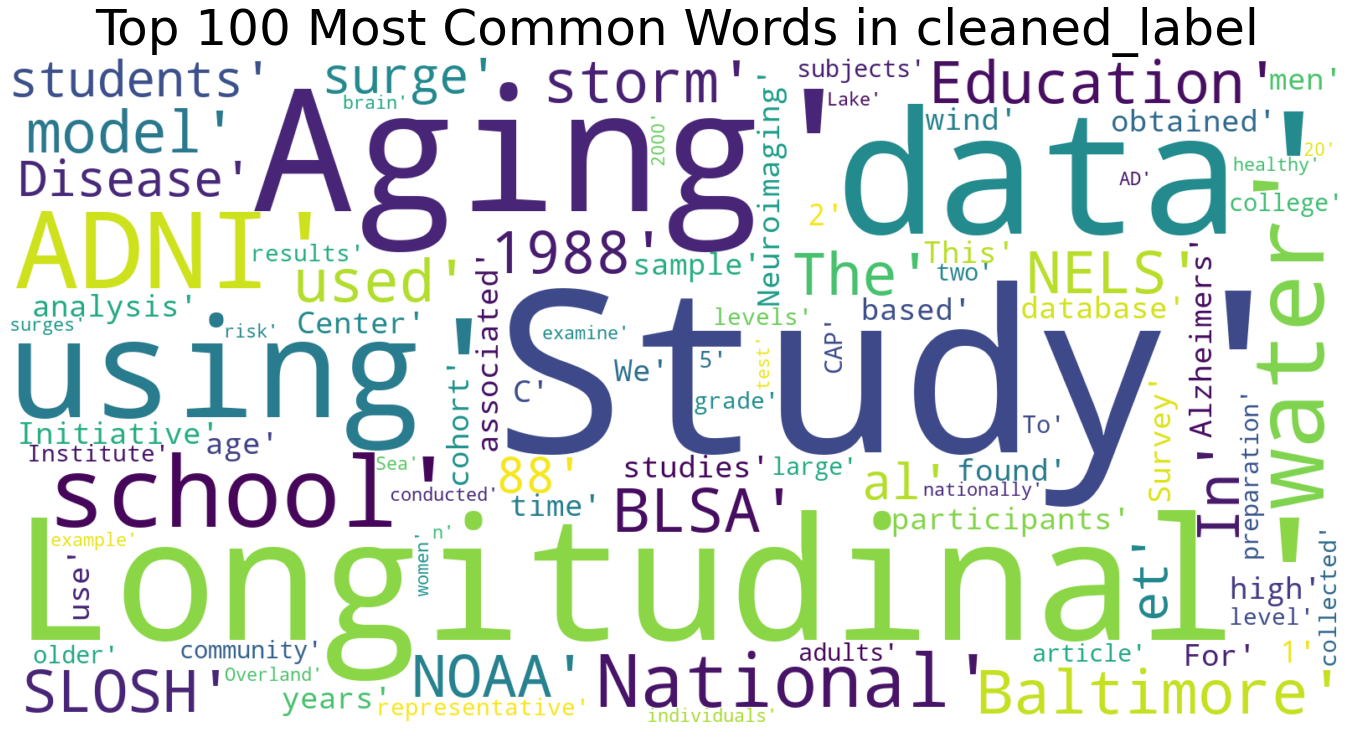

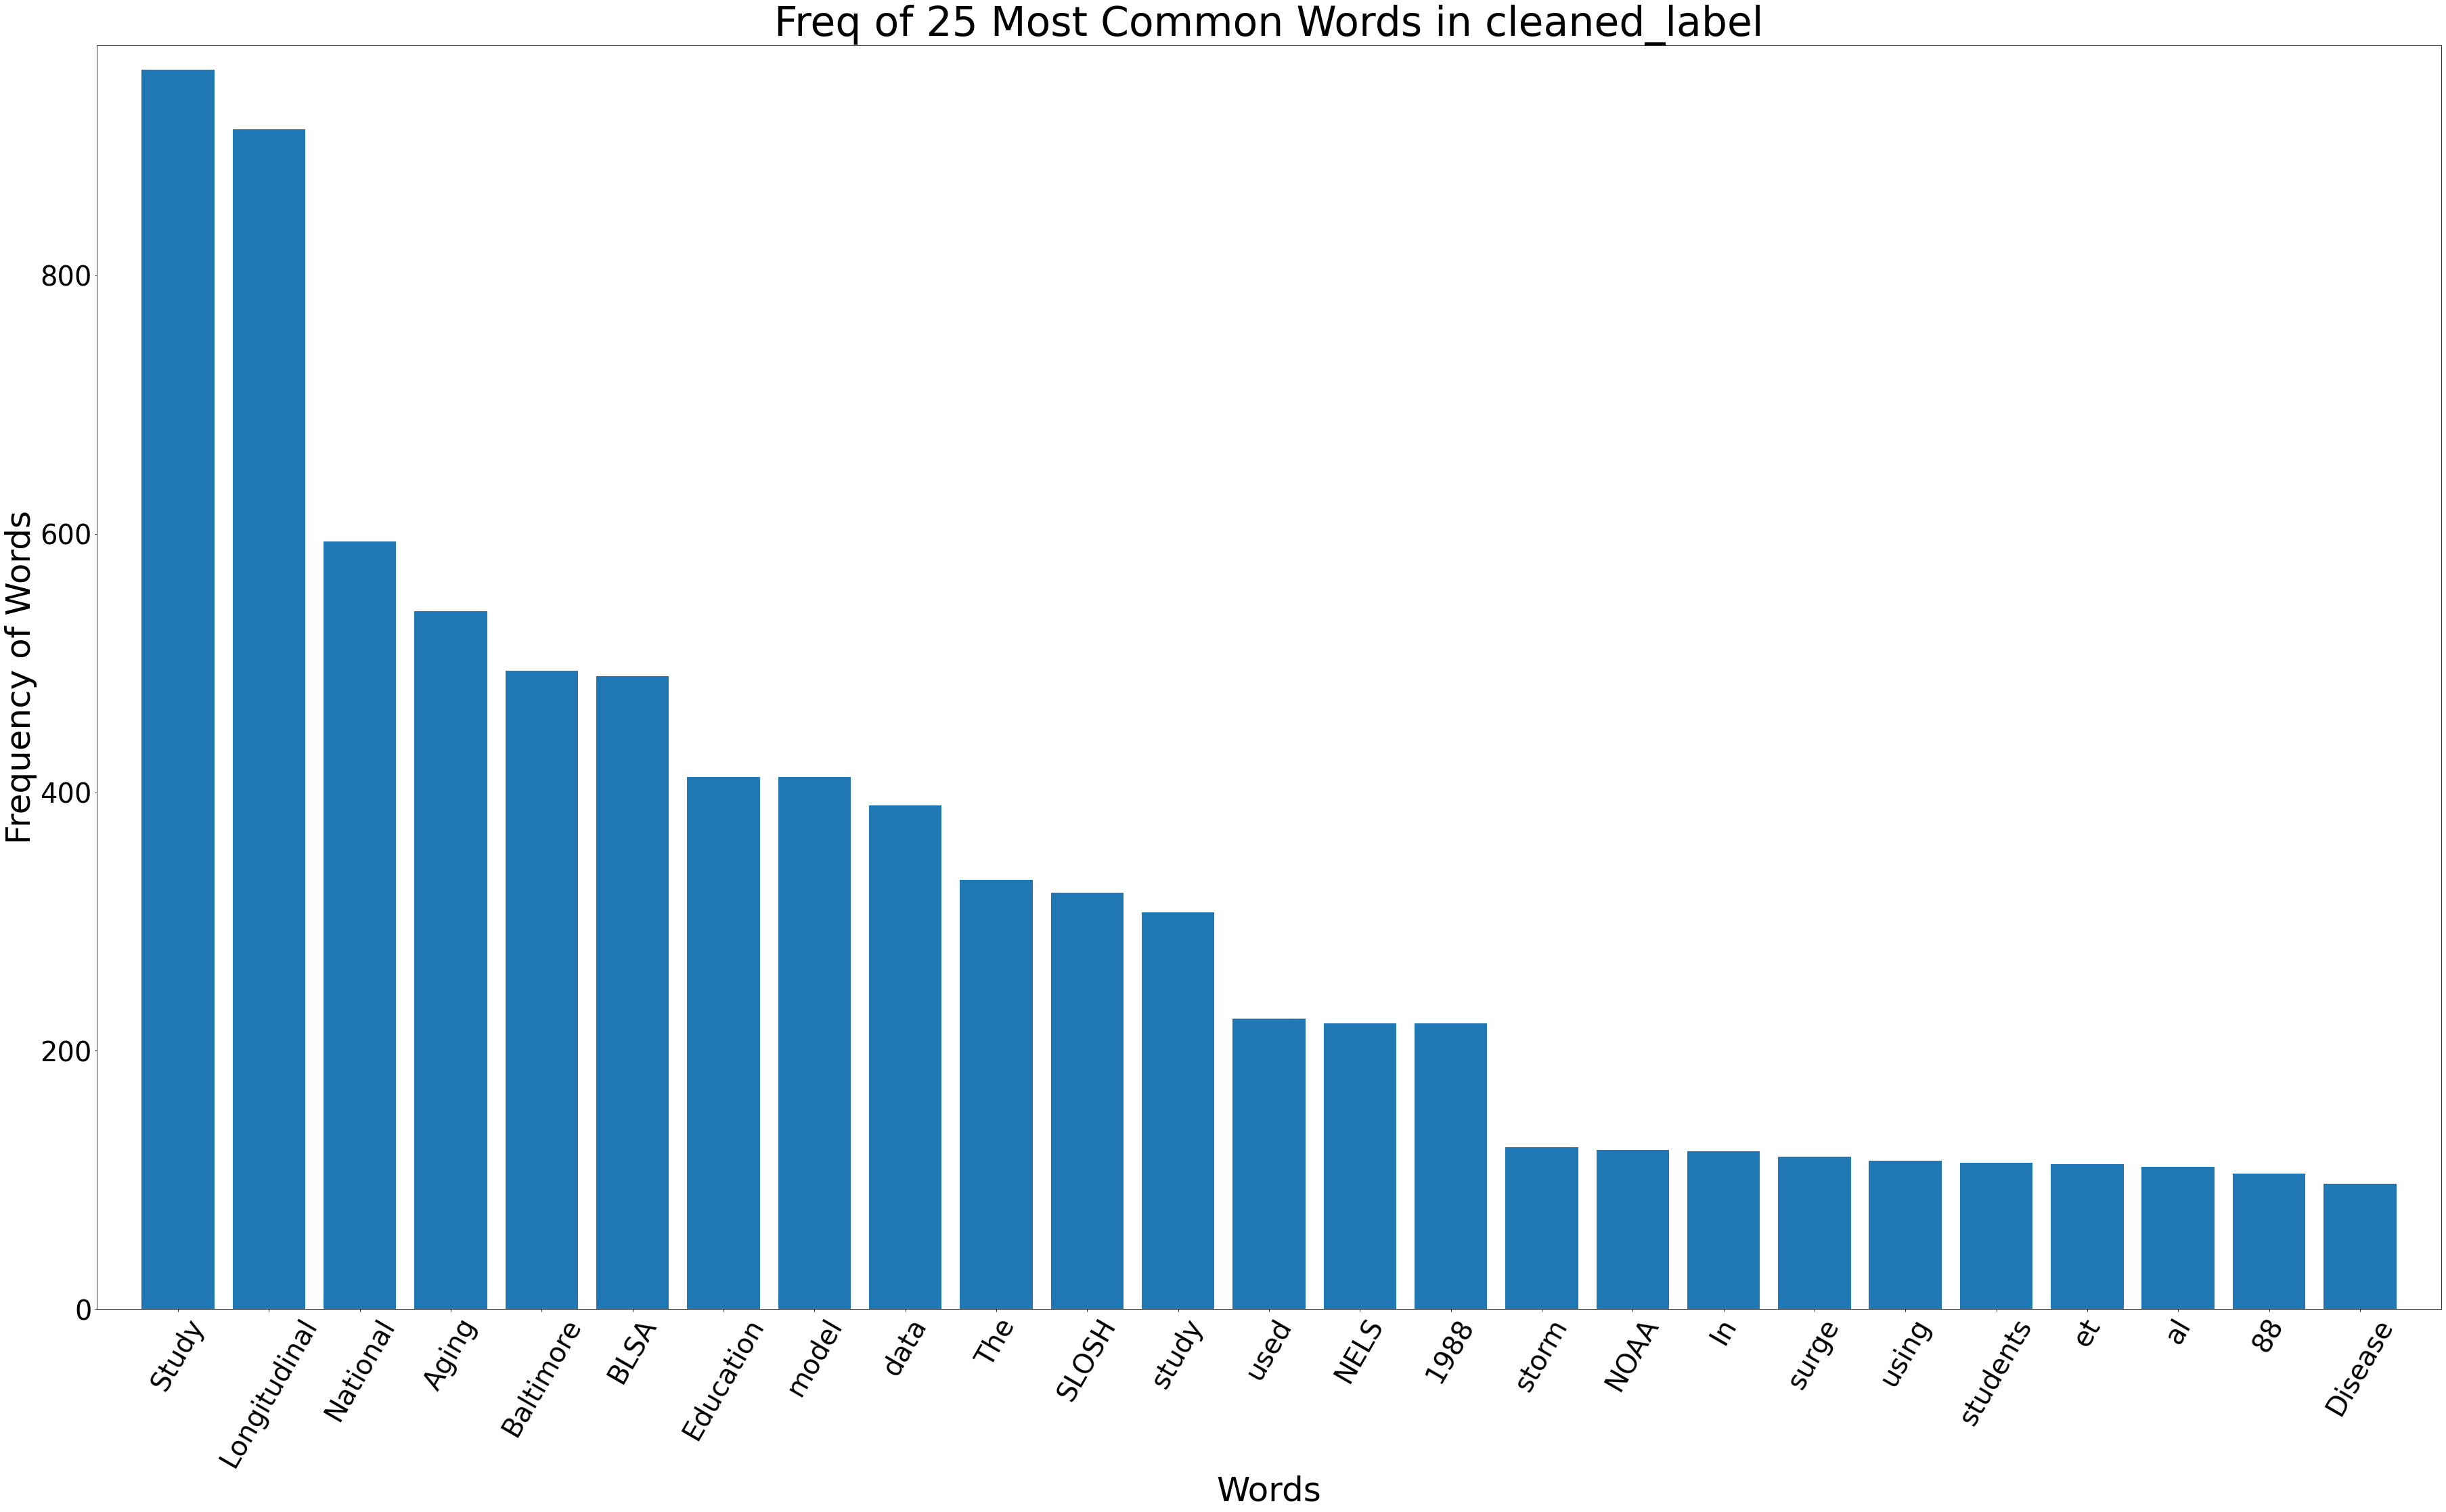

In [49]:

stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
split_words=[]
for word in words_list:
    lo_w=[]
    for w in word:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
#split_words 以句子为单位的列表
allwords = []
for wordlist in split_words:
    allwords += wordlist
#最常出现的一百个词
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=STOPWORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()

In [14]:

#返回ner_data
cnt_pos, cnt_neg = 0, 0 # number of sentences that contain/not contain labels
ner_data = []
papers_train=read_papers(paper_train_folder,train)
pbar = tqdm(total=len(train))
for i, id, dataset_label in train[['Id', 'dataset_label']].itertuples():
    # paper
    paper = papers_train[id]
    
    # labels
    labels = dataset_label.split('|')
    labels = [clean_training_text(label) for label in labels]
    
    # sentences
    sentences = set([clean_training_text(sentence) for section in paper 
                 for sentence in section['text'].split('.') 
                ])
    
    sentences = shorten_sentences(sentences) # make sentences short
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars
    
    # positive sample
    for sentence in sentences:
        is_positive, tags = tag_sentence(sentence, labels)
        if is_positive:
            cnt_pos += 1
            ner_data.append(tags)
        elif any(word in sentence.lower() for word in ['data', 'study']) and cnt_neg<=cnt_pos: 
            
            ner_data.append(tags)
            cnt_neg += 1
    
    # process bar
    pbar.update(1)
    pbar.set_description(f"Training data size: {cnt_pos} positives + {cnt_neg} negatives")

# shuffling
random.shuffle(ner_data)

Training data size: 1341 positives + 1342 negatives: 100%|██████████████████████████| 962/962 [00:05<00:00, 183.77it/s]

In [15]:
words_list,nes_list=[],[]
for row in ner_data:
    words, nes = list(zip(*row))
    words_list.append(list(words))
    nes_list.append(list(nes))


Training data size: 1341 positives + 1342 negatives: 100%|██████████████████████████| 962/962 [00:19<00:00, 183.77it/s]

<AxesSubplot:ylabel='Density'>

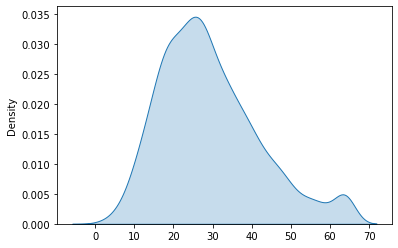

In [28]:
import seaborn as sns
sentence_length=[ len(words) for words in  words_list]
sns.kdeplot(data=sentence_length,shade=True)

In [23]:
#crf标注
import sklearn_crfsuite
from sklearn_crfsuite import CRF   # CRF的具体实现太过复杂，这里我们借助一个外部的库


def word2features(sent, i,pos_sent,compress_list):
    """抽取单个字的特征"""
    word = sent[i]
    postag = pos_sent[i][1]
    compress_tag=compress_list[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        #提取单词后缀，比如ly结尾可能代表副词
        "word[-3:]": word[-3:],
        'word[-2:]': word[-2:],
        #isupper 全为大写
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        
        "compress":compress_tag
    }
    if i > 0:
        #提取前一个单词特征
        word1 = sent[i-1]
        postag1 = pos_sent[i-1][1]
        compress_tag1=compress_list[i-1]
        
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            
            "-1:compress":compress_tag1
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        #提取后一个单词特征
        word1 = sent[i+1]
        postag1 = pos_sent[i+1][1]
        compress_tag1=compress_list[i+1]
        
        features.update({
            '+1:word.lower()': word1.lower(),
            
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            "+1:compress":compress_tag1
        })
    else:
        features['EOS'] = True
        
        
    return features
def get_iscompress(sentence):
    #sentence 是词列表
    stop_list=["of","and","for","in","s"]
    is_compress=[0]*len(sentence)

    for i in range(len(sentence)):
        word=sentence[i]
        word_len=len(word)
        if word.isupper() ==True and word_len>=3 and i>2 :
            flag=False
            m,n=word_len-1,1
            while(i-n>=0):
                pre_word=sentence[i-n]
                if pre_word in stop_list:
                    n=n+1
                    continue
                if pre_word[0]!=word[m]:break
                if m==0:
                    flag=True
                    break
                m,n=m-1,n+1

            if flag==True:
                for k in range(i-n,i+1):
                    is_compress[k]=1
    return is_compress
def sent2features(sent):
    """抽取序列特征"""
    compress_list=get_iscompress(sent)
    pos_sent=nltk.tag.pos_tag(sent)
    return [word2features(sent, i,pos_sent,compress_list) for i in range(len(sent))]



In [24]:
%%time
X_train = [sent2features(s) for s in words_list]
y_train = nes_list



Training data size: 46391 positives + 46392 negatives: 100%|████████████████████| 14029/14029 [02:14<00:00, 135.28it/s]

Wall time: 3min 50s


In [25]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 1min 54s


# 验证集和F1score

In [26]:
def compute_fbeta(y_true,
                  y_pred,
                  beta=0.5) :
    """Compute the Jaccard-based micro FBeta score.

    References
    ----------
    - https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/overview/evaluation
    """

    def _jaccard_similarity(str1: str, str2: str) -> float:
        a = set(str1.split()) 
        b = set(str2.split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    y_true=[ string.split("|") for string in y_true]
    y_pred=[ string.split("|") for string in y_pred]
    tp = 0  # true positive
    fp = 0  # false positive
    fn = 0  # false negative
    for ground_truth_list, predicted_string_list in zip(y_true, y_pred):
        predicted_string_list_sorted = sorted(predicted_string_list)
        for ground_truth in sorted(ground_truth_list):
            if len(predicted_string_list_sorted) == 0:
                fn += 1
            else:
                similarity_scores = [
                    _jaccard_similarity(ground_truth, predicted_string)
                    for predicted_string in predicted_string_list_sorted
                ]
                matched_idx = np.argmax(similarity_scores)
                if similarity_scores[matched_idx] >= 0.5:
                    predicted_string_list_sorted.pop(matched_idx)
                    tp += 1
                else:
                    fn += 1
        fp += len(predicted_string_list_sorted)

    tp *= (1 + beta ** 2)
    fn *= beta ** 2
    fbeta_score = tp / (tp + fp + fn)
    return fbeta_score

In [27]:
def predict_extract(paper_sample_folder,sample_sub):
    papers_sample=read_papers(paper_sample_folder,sample_sub)
    sentences_sample={}
    datasets_all=[]
    def clean_text(txt):
        return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()
    for id in sample_sub['Id'].unique():
        # paper
        paper = papers_sample[id]

        # sentences
        sentences_sample = set([clean_training_text(sentence) for section in paper 
                     for sentence in section['text'].split('.') ])

        sentences_sample = shorten_sentences(sentences_sample) # make sentences short
        sentences_sample = [sentence for sentence in sentences_sample if len(sentence) > 10] 
        sentences_sample=[sentence.split(" ") for sentence in sentences_sample]
        features_sample=[sent2features(s) for s in sentences_sample]

        #预测并提取预测结果
        y_pred = crf.predict(features_sample)
        datasets=[]
        for i  in range(len(y_pred)):
            if "B" in y_pred[i]:
                dataset=""
                for j in range(len(y_pred[i])):
                    if y_pred[i][j]=="B":
                        if dataset!="":
                            dataset=dataset.rstrip()
                            dataset=clean_text(dataset)
                            if dataset  not in datasets:
                                datasets.append(dataset)
                            dataset=""
                        dataset+=sentences_sample[i][j]+" "
                    elif y_pred[i][j]=="I":
                        dataset+=sentences_sample[i][j]+" "
                if dataset!="":
                    dataset=dataset.rstrip()
                    dataset=clean_text(dataset)
                    if dataset  not in datasets:
                        datasets.append(dataset)

        datasets="|".join(datasets)
        datasets_all.append(datasets)
    return datasets_all


In [28]:
validation_pred=predict_extract(paper_train_folder,validation_df)
validation_true=validation_df["cleaned_label"]
f1_validation=compute_fbeta(validation_true,validation_pred)
print(f1_validation)

0.6091277143908723


# 测试集和字符串匹配

In [ ]:
#string matchinf  return literal_preds 
all_labels= set()

for label_1, label_2, label_3 in train[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
    label_1=label_1.split("|")
    label_2=label_2.split("|")
    label_3=label_3.split("|")


    for label in label_1:

        all_labels.add(str(label).lower())
    for label in label_2:
        all_labels.add(str(label).lower())    
    for label in label_3:
        all_labels.add(str(label).lower())


print(f'No. different labels: {len(all_labels)}')


def totally_clean_text(txt):
    txt = clean_text(txt)
    txt = re.sub(' +', ' ', txt)
    return txt
literal_preds = []

for paper_id in sample_sub['Id']:
    paper = papers_sample[paper_id]
    text_1 = '. '.join(section['text'] for section in paper).lower()
    text_2 = totally_clean_text(text_1)
    
    labels = set()
    for label in all_labels:
        if label in text_1 or label in text_2:
            labels.add(clean_text(label))
    
    literal_preds.append('|'.join(labels))
    

In [ ]:
datasets_all=predict_extract(paper_sample_folder,sample_sub)
print("datasets in test data:",datasets_all)
for i in range(len(datasets_all)):
    if literal_preds[i]!="":
        if datasets_all[i]=="":
            datasets_all[i]=literal_preds[i]
        else:
            datasets_all[i]+="|"+literal_preds[i]
    datasets_all[i]=datasets_all[i].split("|")
    datasets_all[i]=list(set(datasets_all[i]))
    datasets_all[i]="|".join(datasets_all[i])
my_submission=pd.DataFrame({"Id":sample_sub['Id'],"PredictionString":datasets_all})
my_submission.to_csv('submission.csv', index=False)

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(collections.Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(collections.Counter(crf.state_features_).most_common()[-30:])

[0, 0, 0, 0, 0, 1, 1, 1, 1]


1
2
3
4
